In [3]:
from IPython.display import display
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

from backbone_classifier import Classifier
from dataset import TripleDataset, load_dataset
from siamese_model import SiameseModel
import utils

random_seed = 42
torch.manual_seed(random_seed)

Training for classifier

In [4]:
dataset_path = "clothing-dataset-small"
batch_size = 32
num_workers = 2
n_epochs = 5
lr = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load train/validation datasets (ImageFolder)
train_dataset, val_dataset = load_dataset(dataset_path)
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

Using device: cuda
Number of classes: 7


In [5]:
model = Classifier(num_classes=num_classes)
class_weights = utils.compute_class_weights(train_loader.dataset)
loss_fcn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.1
)

# Train
trained_model = utils.training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fcn=loss_fcn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    n_epochs=n_epochs,
)

# Save best model weights
torch.save(trained_model.state_dict(), "classifier_best.pth")
print("Saved trained classifier to classifier_best.pth")


-------------Starting training------------


Epoch 1/5 - Train Loss: 2.0215, Train Acc: 0.2878 - Val Loss: 1.5770, Val Acc: 0.3990
-------------Training complete. Best val acc: 0.3990 at epoch 1------------
New best model found at epoch 1 with val acc: 0.3990


Epoch 2/5 - Train Loss: 1.3978, Train Acc: 0.4968 - Val Loss: 1.5768, Val Acc: 0.4615
-------------Training complete. Best val acc: 0.4615 at epoch 2------------
New best model found at epoch 2 with val acc: 0.4615


Epoch 3/5 - Train Loss: 1.2207, Train Acc: 0.5561 - Val Loss: 1.2134, Val Acc: 0.5622
-------------Training complete. Best val acc: 0.5622 at epoch 3------------
New best model found at epoch 3 with val acc: 0.5622


Epoch 4/5 - Train Loss: 1.0713, Train Acc: 0.6268 - Val Loss: 1.0514, Val Acc: 0.6122
-------------Training complete. Best val acc: 0.6122 at epoch 4------------
New best model found at epoch 4 with val acc: 0.6122


Epoch 5/5 - Train Loss: 1.0474, Train Acc: 0.6306 - Val Loss: 1.0477, Val Acc: 0.6261
-------------Training complete. Best val acc: 0.6261 at epoch 5------------
New best model found at epoch 5 with val acc: 0.6261
Saved trained classifier to classifier_best.pth


In [6]:
triple_train_dataset = TripleDataset(train_dataset)

triple_train_loader = DataLoader(
    triple_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

siamese_model = SiameseModel(backbone=trained_model.backbone)
siamese_loss_fcn = nn.TripletMarginLoss(margin=1.0, p=2)
siamese_optimizer = torch.optim.Adam(siamese_model.parameters(), lr=lr)

In [7]:
trained_siamese_model = utils.siamese_training_loop(
    model=siamese_model,
    train_loader=triple_train_loader,
    loss_fcn=siamese_loss_fcn,
    optimizer=siamese_optimizer,
    device=device,
    n_epochs=n_epochs,
)

-------------Starting Siamese training------------


Epoch 1/5 finished, Average Loss: 0.7231
    -> New best model saved (Epoch 0, Loss: 0.7231)


Epoch 2/5 finished, Average Loss: 0.5790
    -> New best model saved (Epoch 1, Loss: 0.5790)


Epoch 3/5 finished, Average Loss: 0.5146
    -> New best model saved (Epoch 2, Loss: 0.5146)


Epoch 4/5 finished, Average Loss: 0.5526


Epoch 5/5 finished, Average Loss: 0.5202

--- Siamese Training Complete ---
Loaded best model weights from Epoch 2 with lowest loss: 0.5146


Query image label: t-shirt

Displaying the 5 most similar items found in the catalog:
Retrieved Item - Class: longsleeve (Index: 47)


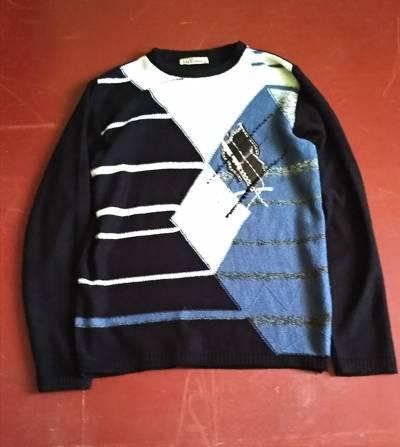

Retrieved Item - Class: dress (Index: 15)


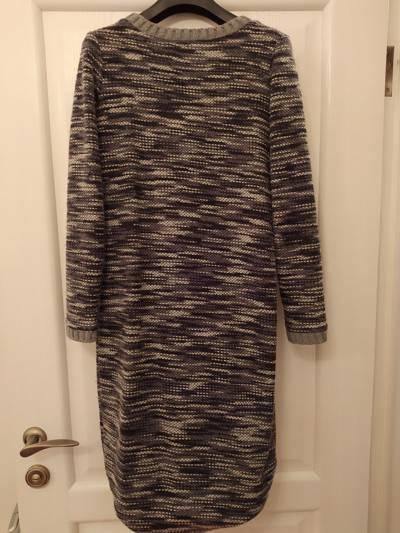

Retrieved Item - Class: t-shirt (Index: 223)


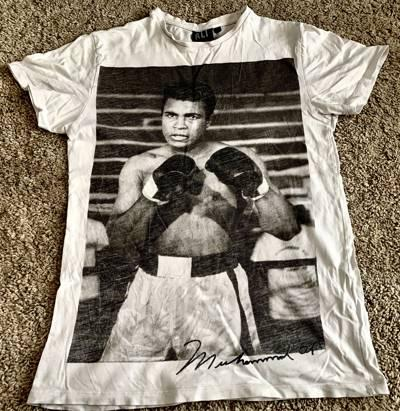

Retrieved Item - Class: dress (Index: 11)


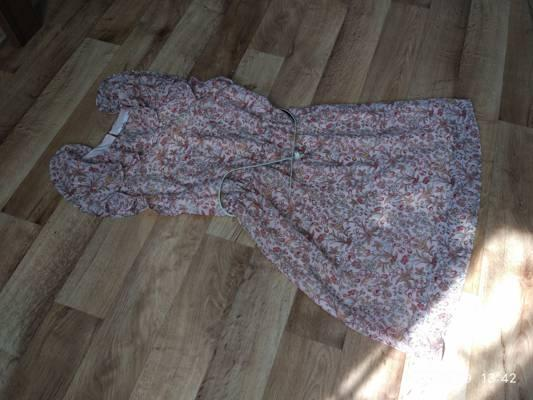

Retrieved Item - Class: dress (Index: 4)


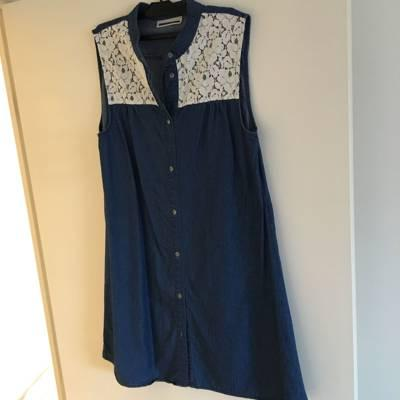

In [ ]:
random_idx = torch.randint(0, len(val_dataset), (1,)).item()
query_image, query_label = utils.get_image(val_dataset, random_idx)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])

query_image_embedding = utils.get_query_img_embedding(trained_siamese_model.encoder, val_transform, query_image, device)

embeddings = utils.get_embeddings(trained_siamese_model.encoder, val_dataset, device)
closest_indices = utils.find_closest(embeddings, query_image_embedding)
print(f"Query image label: {val_dataset.classes[query_label]}")

print(f"\nDisplaying the {5} most similar items found in the catalog:")
for idx_c in closest_indices:
    img_c, label_idx_c = utils.get_image(val_dataset, idx_c) 
    label_c = val_dataset.classes[label_idx_c]

    print(f"Retrieved Item - Class: {label_c} (Index: {idx_c})")
    display(img_c)